<a href="https://colab.research.google.com/github/MilanCugur/Neuroevolution-LocalSearch/blob/master/Baseline_Neuroevolution_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def extract_dataset(path):
  """
  extract DoubledMNIST dataset
  Argument: path to .zip file with the dataset
  Return value: x_train, y_train, x_test, y_test lists of numpy arrays 
  
  (DoubledMNIST dataset: train size 120k images 56x56, test size 20k images 56x56)
  """
  # import libraries
  import os                     # for basic os operations
  from zipfile import ZipFile 
  from skimage import io
  import numpy as np
  import shutil
  
  if not path.endswith('.zip'):
    raise ValueError("Error: path is not '.zip' file")
  
  archive = ZipFile(path, 'r')  # extract
  archive.extractall('./DoubledMNIST')
  archive.close()
  del archive
  
  x_train = []
  y_train = []
  x_test = []
  y_test = []
  
  for file in os.listdir('./DoubledMNIST/train'):
    img = io.imread(os.path.join('./DoubledMNIST/train', file))
    x_train.append(np.array(img))
    y_train.append(int(file.split('_')[1]))
  
  for file in os.listdir('./DoubledMNIST/test'):
    img = io.imread(os.path.join('./DoubledMNIST/test', file))
    x_test.append(np.array(img))
    y_test.append(int(file.split('_')[1]))
    
  shutil.rmtree('./DoubledMNIST')
  return x_train, y_train, x_test, y_test

In [0]:
%%time
_x_train, _y_train, _x_test, _y_test = extract_dataset('./drive/My Drive/ni_sem/DoubledMNIST.zip')

CPU times: user 1min 5s, sys: 16.4 s, total: 1min 21s
Wall time: 1min 24s


In [0]:
BOX_SIZE = 56

In [0]:
from keras.utils import to_categorical
import numpy as np
y_train = to_categorical(_y_train)[:]
y_test = to_categorical(_y_test)[:]

x_train = np.array(_x_train).astype('float32')[:]
x_train /= 255
x_train = np.reshape(x_train,[-1, BOX_SIZE, BOX_SIZE, 1])

x_test = np.array(_x_test).astype('float32')[:]
x_test /= 255
x_test = np.reshape(x_test, [-1, BOX_SIZE, BOX_SIZE, 1])

In [254]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape, x_train[0]

((120000, 56, 56, 1),
 (20000, 56, 56, 1),
 (120000, 10),
 (20000, 10),
 array([[[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [0.84313726],
         [0.8627451 ],
         [0.8745098 ]],
 
        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [0.8156863 ],
         [0.8392157 ],
         [0.85490197]],
 
        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [0.7764706 ],
         [0.8039216 ],
         [0.8235294 ]],
 
        ...,
 
        [[0.9607843 ],
         [0.9529412 ],
         [0.9411765 ],
         ...,
         [0.9019608 ],
         [0.91764706],
         [0.92941177]],
 
        [[0.9843137 ],
         [0.98039216],
         [0.9764706 ],
         ...,
         [0.9607843 ],
         [0.9647059 ],
         [0.96862745]],
 
        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [1.        ],
         [1.        ],
         

In [255]:
print(len(x_train))  # size check
print(len(y_train))
print(len(x_test))
print(len(y_test))

120000
120000
20000
20000


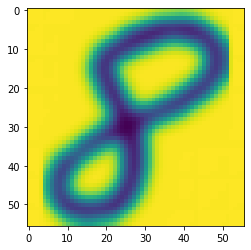

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [256]:
from matplotlib import pyplot as plt  # smal demonstration

plt.imshow(x_test[19].reshape(BOX_SIZE, BOX_SIZE))
plt.show()

print(y_test[19])

# CNN tools

In [0]:
STAGES = np.array(["s1","s2","s3"]) # S
NUM_NODES = np.array([3,4,5])       # K
FILTERS = np.array([32, 48, 64])
individual = [1, 0, 1,   1, 0, 1, 0, 0, 1,  1, 0, 1, 0, 0, 1, 0, 0, 0, 1]

In [0]:
def __create_indices(num_nodes):
  """
  num_nodes - number of nodes per each stage

  Calculate bits indices (startindex, length) for each stage 
  """
  l =  0                              # genome length
  bits_indices, i = np.empty((0,2),dtype = np.int32), 0 
  for Ks in num_nodes:
    length = Ks * (Ks - 1)
    bits_indices = np.vstack([bits_indices,[i, i + int(0.5 * length)]])
    i += int(0.5 * length)
    l += length
  l = int(0.5 * l)
  return bits_indices, l

def CNN_build(stages, num_nodes, n_filters, individual, box_size, n_classes):
  """
  stages - array of stage names
  num_nodes - number of conv nodes per each stage
  n_filters - number of filters per stage
  individual - binary list representing individual architecture
  box_size - expect input images like (box_size, box_size)
  n_classes - number of output clasees

  Build CNN architecture from the given list
  """
  from keras.models import Model
  from keras.layers import Input, Conv2D, MaxPool2D, Add, Activation, Flatten, Concatenate, Dense, Dropout, BatchNormalization
  from keras.optimizers import Adam  
  from keras.losses import categorical_crossentropy
  from keras.layers import LeakyReLU, concatenate
  from keras.layers.advanced_activations import ReLU
  from keras.initializers import glorot_normal
  from keras.utils import to_categorical
  from keras.utils import Sequence
  from sklearn.utils import shuffle
  import keras.backend as K
  from keras.models import load_model  # Save model params

  L = len(individual)
  bits_indices, _L= __create_indices(num_nodes)
  assert(L==_L)  # small check of the input individual connections info

  print('Starting network building..')
  image_shape = (BOX_SIZE, BOX_SIZE, 1) 
  x_input = Input(shape=image_shape)  
  previous = None # output from previous stage (initially input of CNN)
  # Build stage by stage
  for i, (s, Ks, n_filter) in enumerate(zip(stages, num_nodes, n_filters)):
    if i==0:
      previous = x_input
    print('\nBuild layer', s, ':', Ks, 'nodes,', n_filter, 'filters.')
    stage_indices = individual[bits_indices[i][0]:bits_indices[i][1]]                  # connection indices for current stage nodes; ex. [1, 0, 1, 0, 0, 1, 0, 0, 0, 1]
    stage_indexes = np.split(range(int(Ks*(Ks-1)/2)),np.cumsum(range(Ks - 1)))[1:]     # connection indexes for current stage nodes; ex. [array([0]), array([1, 2]), array([3, 4, 5]), array([6, 7, 8, 9])]
    stage_nodes = []                                                                   # nodes in a stage; ex. [vs1_1, vs1_2, vs1_3] (0, 4 are dummy)
    to_him = np.zeros(Ks)                                                              # number of nodes to which i-th node points to
    from_him = np.zeros(Ks)                                                            # number of nodes from i-th node to others
    print('Stage indices:', stage_indices)
    print('Stage indexes:', stage_indexes)

    # default stage input node
    print('Building '+'v'+str(s)+'_0')
    vs0 = Conv2D(filters=n_filter, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', name='v'+str(s)+'_0')(previous)  # TODO
    print('Builded '+'v'+str(s)+'_0')

    # first node and trivial vs0->vs1
    print('Building '+'v'+str(s)+'_1')
    vs1 = Conv2D(filters=n_filter, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', name='v'+str(s)+'_1')(vs0) 
    stage_nodes += [vs1]
    print('Builded '+'v'+str(s)+'_1')

    for j in range(2, Ks+1):
      name = 'v'+str(s)+'_'+str(j)  # name of the current node
      print('Building '+name)
      #print('Previous nodes: ', stage_nodes)
      tonode = stage_indices[stage_indexes[j-2][0]:stage_indexes[j-2][-1]+1]  # slice from stage_indices
      input = None  # Input to current node
      if sum(tonode)==0:  # empty input, connect to vs0
        input = vs0
      else:  # have some input
        for k, connection in enumerate(tonode):
          if connection==1:
            from_him[k] += 1
            to_him[j-1] += 1
            if input is None:
              input = stage_nodes[k]
            else:
              input = Add()([input, stage_nodes[k]])
        v = Conv2D(filters=n_filter, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', name='v'+str(s)+'_'+str(j))(input) 
        stage_nodes += [v]
        print('Builded node '+name)

    print('from_him: ', from_him)
    print('to_him: ', to_him)

    for k in range(Ks):
      if from_him[k]==0 and to_him[k]==0:  # isolate nodes delete
        del stage_nodes[k]

    print('Building '+'v'+str(s)+'_'+str(Ks+1))
    input = stage_nodes[-1]  # last node no output definitelly
    for k in range(len(to_him)):
      if from_him[k]==0:  # no connections from that node
        input = Add()([input, stage_nodes[k]])
    vsKs = Conv2D(filters=n_filter, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', name='v'+str(s)+'_'+str(Ks+1))(input) # defaul stage output node
    print('Builded '+'v'+str(s)+str(Ks+1))
    previous = MaxPool2D(pool_size=(2,2), padding='same')(vsKs)
  
  # Adding FC part of NN
  x = Flatten(name='flatten')(previous)                                                                                       
  x = Dense(units=32, activation='relu', name='next_to_last')(x)         
  x = Dense(units=n_classes, activation='softmax', name='last')(x)

  # Creaate Model
  model = Model(inputs=x_input, outputs=x, name='individual')
  print('Created Network builded.')
  return model

In [259]:
model = CNN_build(STAGES, NUM_NODES, FILTERS, individual, 56, 10)

Starting network building..

Build layer s1 : 3 nodes, 32 filters.
Stage indices: [1, 0, 1]
Stage indexes: [array([0]), array([1, 2])]
Building vs1_0
Builded vs1_0
Building vs1_1
Builded vs1_1
Building vs1_2
Builded node vs1_2
Building vs1_3
Builded node vs1_3
from_him:  [1. 1. 0.]
to_him:  [0. 1. 1.]
Building vs1_4
Builded vs14

Build layer s2 : 4 nodes, 48 filters.
Stage indices: [1, 0, 1, 0, 0, 1]
Stage indexes: [array([0]), array([1, 2]), array([3, 4, 5])]
Building vs2_0
Builded vs2_0
Building vs2_1
Builded vs2_1
Building vs2_2
Builded node vs2_2
Building vs2_3
Builded node vs2_3
Building vs2_4
Builded node vs2_4
from_him:  [1. 1. 1. 0.]
to_him:  [0. 1. 1. 1.]
Building vs2_5
Builded vs25

Build layer s3 : 5 nodes, 64 filters.
Stage indices: [1, 0, 1, 0, 0, 1, 0, 0, 0, 1]
Stage indexes: [array([0]), array([1, 2]), array([3, 4, 5]), array([6, 7, 8, 9])]
Building vs3_0
Builded vs3_0
Building vs3_1
Builded vs3_1
Building vs3_2
Builded node vs3_2
Building vs3_3
Builded node vs3_3
Buildi

In [0]:
def compile_model(model):
  """
  model - created Keras model

  Compile forwarded model, and return it compiled
  """
  from keras.optimizers import Adam  
  from keras.losses import categorical_crossentropy

  model.compile(optimizer=Adam(lr=1e-3), loss=categorical_crossentropy, metrics=['accuracy'])
  return model

In [0]:
model = compile_model(model)

In [0]:
def visualise_model(model):
  """
  model - created Keras model

  plot forwarded model architecture
  """
  from keras.utils import plot_model

  print('Model summary: ')
  model.summary()
  plot_model(model, to_file='model.png')
  return

In [263]:
visualise_model(model)

Model summary: 
Model: "individual"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_99 (InputLayer)           (None, 56, 56, 1)    0                                            
__________________________________________________________________________________________________
vs1_0 (Conv2D)                  (None, 56, 56, 32)   320         input_99[0][0]                   
__________________________________________________________________________________________________
vs1_1 (Conv2D)                  (None, 56, 56, 32)   9248        vs1_0[0][0]                      
__________________________________________________________________________________________________
vs1_2 (Conv2D)                  (None, 56, 56, 32)   9248        vs1_1[0][0]                      
_________________________________________________________________________

In [0]:
def train_model(model, x_train, y_train, x_test, y_test, epochs, batch_size, verbose=1, validation_split=0.0):
  """
  model - compiled CNN model
  x_train - input images
  y_train - input labels (one hot encoded)
  x_test - test images
  y_test - test labels (one hot encoded)
  epochs - number of epochs
  batch_size - mini batch size of training
  verbose - verbose of training
  validation_split - data split used for validation

  Train forwrded model. Return (train history, model obtained test accuracy)
  """
  history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
  return history, model.evaluate(x_test, y_test)

In [265]:
train_model(model, x_train, y_train, x_test, y_test, 10, 50, 1)

Epoch 1/10
 95250/120000 [======================>.......] - ETA: 46s - loss: 0.1816 - acc: 0.9420

KeyboardInterrupt: ignored

# Genetic Algorithm

In [0]:
# Dimitrijevic kuca kod

In [0]:
STAGES = np.array(["s1","s2","s3"]) # S
NUM_NODES = np.array([3,4,5])       # K

L =  0                              # genome length
BITS_INDICES, l_bpi = np.empty((0,2),dtype = np.int32), 0 # to keep track of bits for each stage S
for Ks in NUM_NODES:
    t = Ks * (Ks - 1)
    BITS_INDICES = np.vstack([BITS_INDICES,[l_bpi, l_bpi + int(0.5 * t)]])
    l_bpi += int(0.5 * t)
    L += t
L = int(0.5 * L)

In [0]:
BITS_INDICES, L

(array([[ 0,  3],
        [ 3,  9],
        [ 9, 19]]), 19)

In [0]:
TRAINING_EPOCHS = 10 # T
BATCH_SIZE = 20
TOTAL_BATCHES = train_imgs.shape[0] // BATCH_SIZE

In [252]:
_y_train[:1000]

[2,
 4,
 1,
 9,
 8,
 3,
 5,
 4,
 2,
 5,
 2,
 9,
 4,
 3,
 7,
 0,
 4,
 2,
 3,
 3,
 0,
 8,
 8,
 5,
 8,
 3,
 9,
 5,
 3,
 7,
 9,
 0,
 0,
 1,
 4,
 0,
 1,
 0,
 5,
 6,
 5,
 4,
 7,
 6,
 6,
 3,
 3,
 5,
 7,
 1,
 4,
 6,
 2,
 3,
 2,
 2,
 7,
 3,
 3,
 9,
 8,
 6,
 7,
 1,
 5,
 6,
 8,
 2,
 3,
 9,
 8,
 7,
 4,
 1,
 1,
 2,
 4,
 0,
 4,
 1,
 3,
 8,
 4,
 5,
 2,
 8,
 8,
 8,
 4,
 2,
 7,
 0,
 8,
 5,
 4,
 8,
 5,
 5,
 8,
 1,
 6,
 7,
 6,
 5,
 7,
 1,
 3,
 8,
 1,
 5,
 6,
 7,
 2,
 3,
 4,
 5,
 4,
 3,
 4,
 2,
 0,
 7,
 2,
 9,
 6,
 1,
 9,
 7,
 4,
 6,
 4,
 3,
 8,
 9,
 0,
 9,
 9,
 6,
 3,
 8,
 8,
 4,
 3,
 8,
 5,
 2,
 8,
 0,
 1,
 9,
 8,
 1,
 7,
 9,
 7,
 5,
 7,
 1,
 0,
 4,
 8,
 4,
 5,
 2,
 2,
 8,
 9,
 2,
 4,
 8,
 4,
 1,
 6,
 9,
 2,
 5,
 6,
 2,
 7,
 0,
 9,
 0,
 3,
 7,
 5,
 3,
 8,
 5,
 5,
 0,
 4,
 0,
 4,
 9,
 2,
 1,
 5,
 5,
 1,
 3,
 6,
 0,
 2,
 8,
 4,
 8,
 5,
 9,
 5,
 0,
 5,
 5,
 7,
 6,
 6,
 6,
 8,
 5,
 0,
 7,
 5,
 0,
 4,
 2,
 8,
 3,
 8,
 0,
 7,
 9,
 2,
 2,
 9,
 0,
 6,
 1,
 1,
 6,
 6,
 2,
 5,
 6,
 5,
 3,
 5,
 5,
 6,
 6,
 9,
 4,


# Resources

* Google Schoolar Searches: [link](https://scholar.google.com/scholar?hl=sr&as_sdt=0%2C5&q=genetic+cnn+handwritting&btnG=)

* Fokus na rad: 
 * .pdf: [link](https://arxiv.org/abs/1703.01513)
 * github: [link](https://arxiv.org/abs/1703.01513)
* Dodatno rad:
 *  .pdf: [link](https://arxiv.org/pdf/1710.10741.pdf)
 * Clanak na netu: [link](https://blog.coast.ai/lets-evolve-a-neural-network-with-a-genetic-algorithm-code-included-8809bece164)
* Ako sami implementiramo: [link](https://github.com/joeddav/devol/blob/master/devol/devol.py)
